## Cargar Archivos de Excel

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_doctors = pd.read_excel('../data/raw/doctors.xlsx')
print(df_doctors.head())

   doctor_id           name specialty
0        100      Dr. Pérez      Vein
1        101      Dr. Gómez      Pain
2        102    Dr. Sánchez      Vein
3        103  Dr. Rodríguez      Pain
4        104   Dr. Martínez      Vein


In [4]:
df_appointments = pd.read_excel('../data/raw/appointments.xlsx')
print(df_appointments.head())

  booking_id  patient_id  doctor_id booking_date     status
0          1        10.0      100.0   10/20/2025  confirmed
1          2        11.0      101.0   10/21/2025  cancelled
2          3        12.0      100.0   10/20/2025  confirmed
3          4        13.0      101.0   10/20/2025  confirmed
4          5        14.0      102.0   10/20/2025  cancelled


# Data Quality Analysis for Appointments


In [5]:

print("\n\n\n Información general de df_doctors:")
df_doctors.info()

print("\n\n\n descriptivas de df_doctors:")
print(df_doctors.describe())

print("\n\n\n Valores únicos de la columna 'specialty' en df_doctors:")
print(df_doctors['specialty'].unique())




 Información general de df_doctors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   doctor_id  5 non-null      int64 
 1   name       5 non-null      object
 2   specialty  5 non-null      object
dtypes: int64(1), object(2)
memory usage: 252.0+ bytes



 descriptivas de df_doctors:
        doctor_id
count    5.000000
mean   102.000000
std      1.581139
min    100.000000
25%    101.000000
50%    102.000000
75%    103.000000
max    104.000000



 Valores únicos de la columna 'specialty' en df_doctors:
['Vein' 'Pain']


# Appointments Data Quality Analysis

In [6]:

print(" Información general de df_appointments:")
df_appointments.info()

print("\n\n\nEstadísticas descriptivas de df_appointments:")
print(df_appointments.describe())

print("\n\n\n Valores únicos de la columna 'status' en df_appointments:")
print(df_appointments['status'].unique())

 Información general de df_appointments:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   booking_id    1025 non-null   object 
 1   patient_id    1022 non-null   float64
 2   doctor_id     1025 non-null   float64
 3   booking_date  1025 non-null   object 
 4   status        1025 non-null   object 
dtypes: float64(2), object(3)
memory usage: 40.2+ KB



Estadísticas descriptivas de df_appointments:
        patient_id    doctor_id
count  1022.000000  1025.000000
mean     33.665362   102.443902
std      14.073389     1.761964
min      10.000000   100.000000
25%      22.000000   101.000000
50%      34.000000   102.000000
75%      46.000000   104.000000
max      58.000000   105.000000



 Valores únicos de la columna 'status' en df_appointments:
['confirmed' 'cancelled' 'canceled' 'Confirmed' 'confirmed ' 'confirmed.'
 'cancelled ']


In [7]:
print("\n Valores faltantes en df_doctors:")
print(df_doctors.isnull().sum())

print("\n Filas duplicadas en df_doctors:")
print(df_doctors.duplicated().sum())


 Valores faltantes en df_doctors:
doctor_id    0
name         0
specialty    0
dtype: int64

 Filas duplicadas en df_doctors:
0


In [8]:
print("\n### Data quality checks:")
print("Missing values per column:")
print(df_appointments.isnull().sum())

print("\nDuplicate rows count:")
print(df_appointments.duplicated().sum())



### Data quality checks:
Missing values per column:
booking_id      0
patient_id      3
doctor_id       0
booking_date    0
status          0
dtype: int64

Duplicate rows count:
0


## Cleaning Data



In [9]:
def clean_id_column(series: pd.Series) -> pd.Series:
    def clean_value(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, np.integer)):
            return int(x)
            
        if isinstance(x, (float, np.floating)):
            return int(x)

        if isinstance(x, str):
            x = x.strip()
            x = re.sub(r'[^0-9\.]', '', x)

            if x == '':
                return np.nan

            try:
                return int(float(x)) 
            except ValueError:
                return np.nan

        return np.nan

    return series.apply(clean_value).astype("Int64")

In [10]:
def clean_date_column(series: pd.Series) -> pd.Series:

    def parse_date(x):
        if pd.isna(x):
            return pd.NaT

        x = str(x).strip()
        x = re.sub(r'[^0-9/-]', '', x)

        if x == '':
            return pd.NaT

        # YYYY-MM-DD
        if re.fullmatch(r'\d{4}-\d{2}-\d{2}', x):
            return pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')

        # YYYY/MM/DD
        if re.fullmatch(r'\d{4}/\d{2}/\d{2}', x):
            return pd.to_datetime(x, format='%Y/%m/%d', errors='coerce')

        # MM-DD-YYYY → MM/DD/YYYY
        if re.fullmatch(r'\d{2}-\d{2}-\d{4}', x):
            x = x.replace('-', '/')

        # MM/DD/YYYY
        if re.fullmatch(r'\d{2}/\d{2}/\d{4}', x):
            return pd.to_datetime(x, format='%m/%d/%Y', errors='coerce')

        return pd.NaT

    return series.apply(parse_date)


In [11]:
print("### Starting df_appointments cleaning process")
before_cleaning = len(df_appointments)
print(f"Initial number of records: {before_cleaning}")

# --- ID columns cleaning ---
for col in ['booking_id', 'patient_id', 'doctor_id']:
    df_appointments[col] = clean_id_column(df_appointments[col])

df_appointments.dropna(subset=['patient_id'], inplace=True)
print(f"Records after removing null patient_id: {len(df_appointments)}")

print("ID columns (booking_id, patient_id, doctor_id) successfully cleaned and casted.")

# --- Booking date cleaning ---
df_appointments['booking_date'] = clean_date_column(
    df_appointments['booking_date']
)
df_appointments.dropna(subset=['booking_date'], inplace=True)
print("booking_date column cleaned and converted to datetime.")

# --- Status normalization ---
df_appointments['status'] = (
    df_appointments['status']
    .astype(str)
    .str.lower()
    .str.replace(r'[^a-z]', '', regex=True)
)

df_appointments['status'] = (
    df_appointments['status']
    .str.replace(r'^cancel.*', 'cancelled', regex=True)
    .str.replace(r'^confirm.*', 'confirmed', regex=True)
)
print("status column normalized using regex-based rules.")

# --- Data preview & schema ---
print("\n### Cleaned df_appointments preview:")
print(df_appointments.head())

print("\n### Updated DataFrame info:")
df_appointments.info()

# --- Duplicates check ---
duplicate_count = df_appointments.duplicated().sum()
print(f"\nDuplicate records detected: {duplicate_count}")

print("Removing duplicate records...")
df_appointments.drop_duplicates(inplace=True)

# --- Null values summary ---
print("\n### Null values summary after cleaning:")
print(df_appointments.isnull().sum())

print("\n### Cleaning summary")
print(f"Rows before cleaning: {before_cleaning}")
print(f"Rows after cleaning:  {len(df_appointments)}")
print(f"Rows removed during cleaning: {before_cleaning - len(df_appointments)}")


### Starting df_appointments cleaning process
Initial number of records: 1025
Records after removing null patient_id: 1022
ID columns (booking_id, patient_id, doctor_id) successfully cleaned and casted.
booking_date column cleaned and converted to datetime.
status column normalized using regex-based rules.

### Cleaned df_appointments preview:
   booking_id  patient_id  doctor_id booking_date     status
0           1          10        100   2025-10-20  confirmed
1           2          11        101   2025-10-21  cancelled
2           3          12        100   2025-10-20  confirmed
3           4          13        101   2025-10-20  confirmed
4           5          14        102   2025-10-20  cancelled

### Updated DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 0 to 1024
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   booking_id    928 non-null    Int64         
 1   pati

## Visualization

In [12]:
def plot_appointment_by_time(appointments_df):
    appointments_by_date = (
        appointments_df
        .groupby('booking_date')
        .size()
        .reset_index(name='count')
    )

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=appointments_by_date, x='booking_date', y='count', marker='o')
    plt.title('Appointment Frequency Over Time')
    plt.xlabel('Appointment Date')
    plt.ylabel('Number of Appointments')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


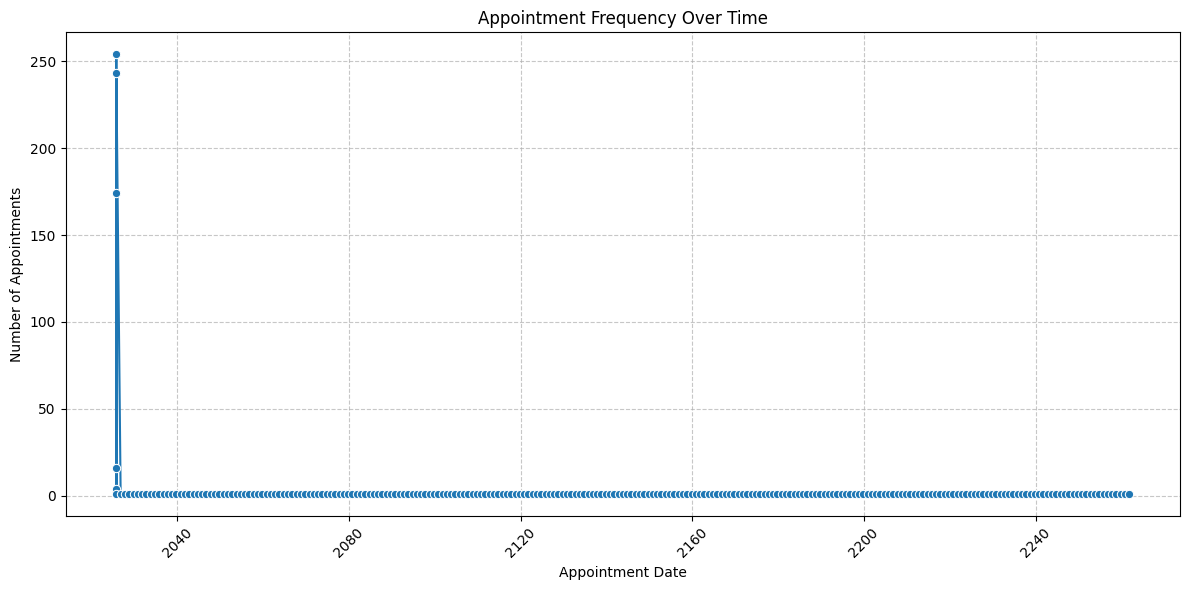

In [13]:
plot_appointment_by_time(df_appointments)

### Note: 

Date values that fail format validation are converted to NULL as part of the ETL data quality controls, allowing downstream auditing and validation.

In [14]:
evaluations=df_appointments.copy()
evaluations['year'] = evaluations['booking_date'].dt.year

appointments_per_year = (
    evaluations
    .groupby('year')
    .size()
    .reset_index(name='total_appointments')
    .sort_values('year')
)

print(appointments_per_year)

     year  total_appointments
0    2025                 692
1    2026                   1
2    2027                   1
3    2028                   1
4    2029                   1
..    ...                 ...
232  2257                   1
233  2258                   1
234  2259                   1
235  2260                   1
236  2261                   1

[237 rows x 2 columns]


In [15]:
current_year = pd.Timestamp.today().year
max_allowed_year = current_year 

df_appointments['booking_date_valid'] = (
    df_appointments['booking_date'].dt.year <= max_allowed_year
)

df_appointments.loc[
    ~df_appointments['booking_date_valid'],
    'booking_date'
] = pd.NaT

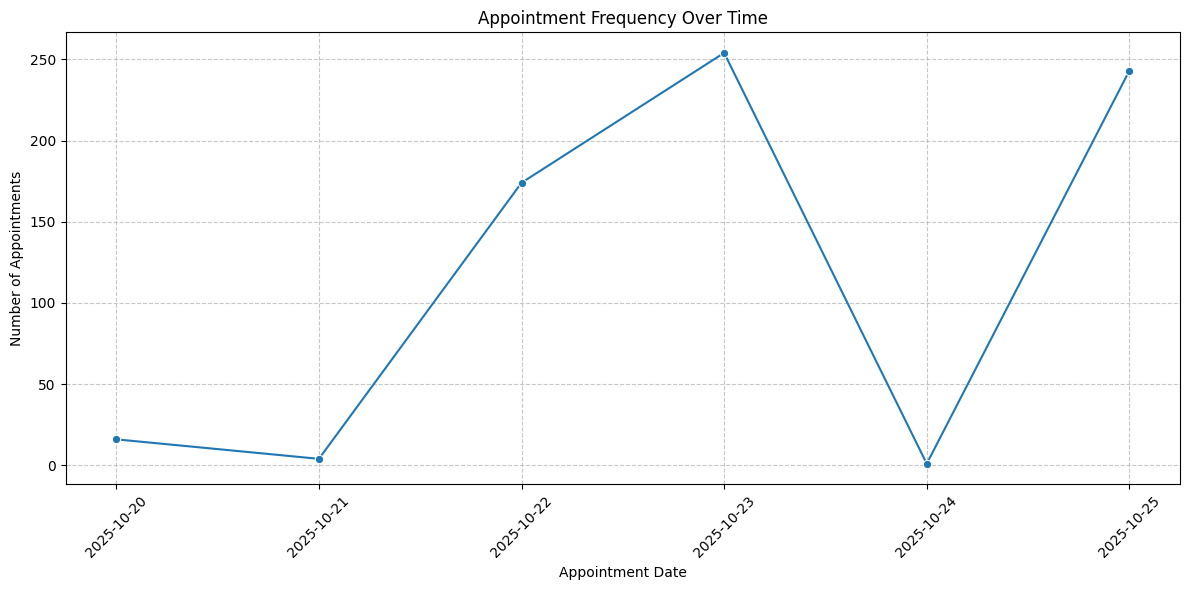

In [16]:
plot_appointment_by_time(df_appointments)

/tmp/ipykernel_16262/706620738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_doctors, x='specialty', palette='viridis')


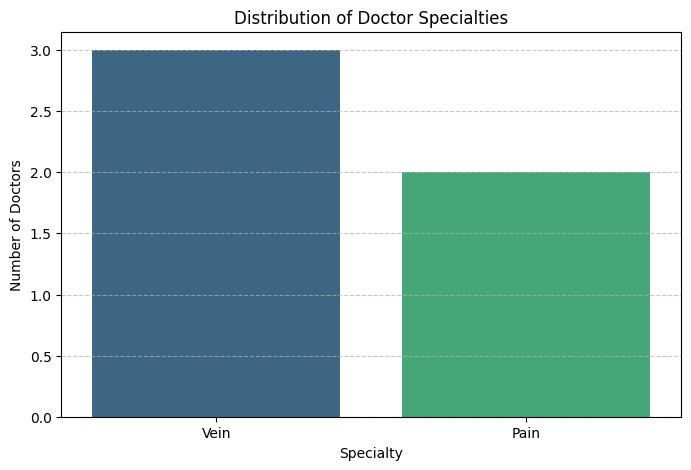

In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_doctors, x='specialty', palette='viridis')
plt.title('Distribution of Doctor Specialties')
plt.xlabel('Specialty')
plt.ylabel('Number of Doctors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/tmp/ipykernel_16262/220625456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_appointments, x='status', palette='coolwarm')


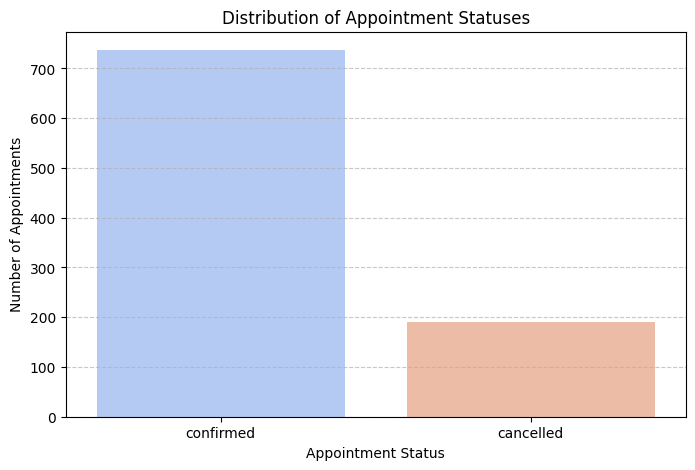

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_appointments, x='status', palette='coolwarm')
plt.title('Distribution of Appointment Statuses')
plt.xlabel('Appointment Status')
plt.ylabel('Number of Appointments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/tmp/ipykernel_16262/220625456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_appointments, x='status', palette='coolwarm')


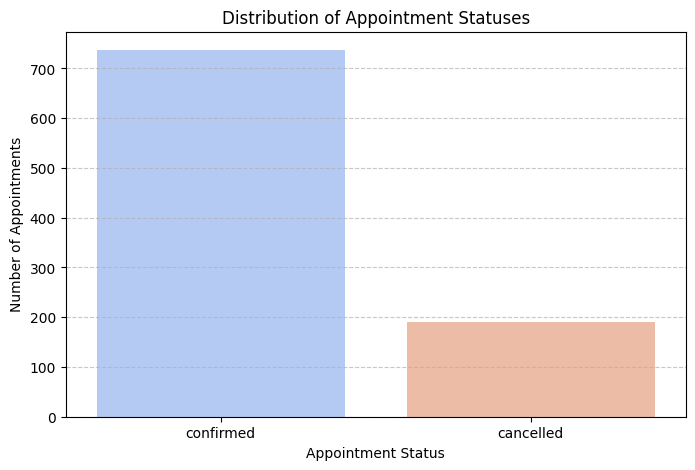

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_appointments, x='status', palette='coolwarm')
plt.title('Distribution of Appointment Statuses')
plt.xlabel('Appointment Status')
plt.ylabel('Number of Appointments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ETL Proposal